In [63]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

### Preparing and loading DATA

* Excel spreadsheet
* Images
* Videos
* Audios
* DNA
* Text

Machine is 2 parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation

In [64]:
# Using linear regression formula
# Create *known* parameters

weight = 0.7 # Gradient
bias = 0.3 # y intercept

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [65]:
len(X), len(y)

(50, 50)

### Split data into training and test sets (most important), validation set (like a mock exam) is often but not always



In [66]:
# 80-20 split for training and test sets
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [67]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot predictions if have
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Legend
  plt.legend(prop={"size": 14});


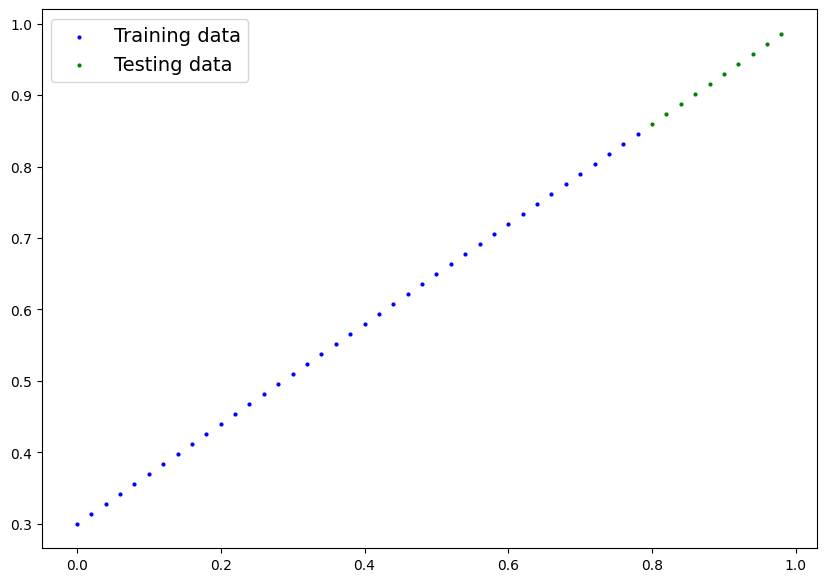

In [122]:
plot_predictions();

## Building first PyTorch model

What the model does:
1) Start with random values of weight and bias
2) Look at training data and adjust the random values to better represent the ideal values

How?
1. Gradient Descent (why later requires_grad=True)

2. Backpropagation

In [69]:

# Linear regression (Y = a + bX)

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from this nn.module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # Start with a random weight
                                              dtype=torch.float),
                                    requires_grad=True) # actually default is true)

        self.bias = nn.Parameter(torch.randn(1,  # Start with a random bias
                                              dtype=torch.float),
                                requires_grad=True) # actually default is true)

    # Forward method to define computation
    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data, return type is a tensor
        return self.weights * x + self.bias # linear regression formula

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (neural network can be considered such a graph)
* torch.nn.Paramenter - what parameters should our model try and learn, a pytorch layer from torch.nn will usually set these
* torch.nn.Module - base class for all neural network modules, if subclass it, must overwrite forward()
* torch.optim - where optimisers in PyTorch live to help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [70]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

## Checking contents of PyTorch model

Check our model parameters or what's inside our models using `.parameters()`

In [71]:

# Create a random seed (for reproducibility)
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [72]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts y_test based on X_test

When we pass data through our model, it's going to run it through the forward method

In [73]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [74]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [75]:
# Make predictions with model
# Inference mode turns off the gradient tracking, fewer data, faster processing for predictions
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

# You can do something similar with torch.no_grad() but inference_mode is preferred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

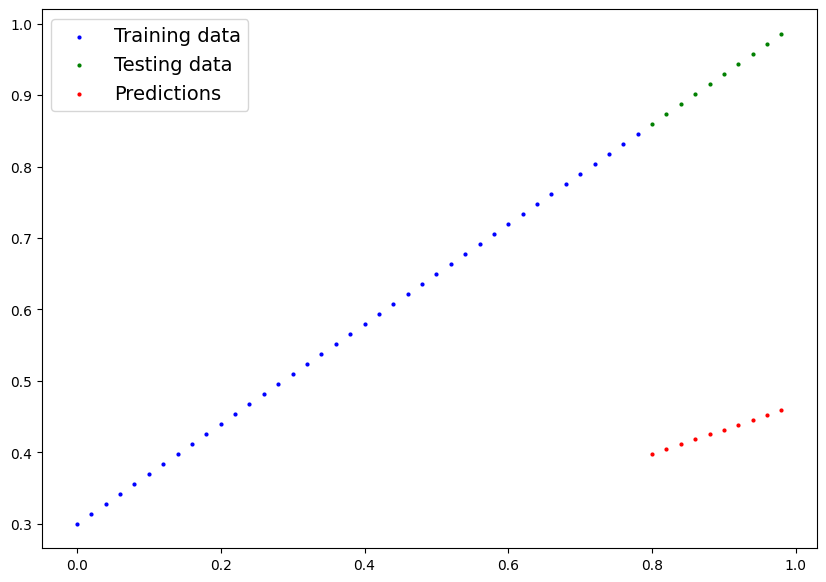

In [76]:
plot_predictions(predictions=y_preds)

## Train model

Training is for a model to move from some unknown parameters (could be random) to some known parameters

To check how poor the predictions are doing, we can make a loss function.

* Note: Loss function may also be called cost function or crierion

Things we need to train:

* **Loss function:** A function to measure how wrong the model's predictions are to the ideal ouputs, lower the better

* **Optimizer:** Takes into account the loss of a model and adjusts the models' parameters (e.g. weight/bias) to decrease the loss

For PyTorch we need
1. Training loop
2. Testing loop

In [77]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [78]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [79]:
# Setup a loss function
loss_fn = nn.L1Loss() # this function uses Mean Absolute Error (MAE)

# Setup an optimizer (takes into account the loss of a model)
# Using SGD (stochastic (random) gradient descent), randomly adjust values to minimise loss
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = most important hyper parameter, higher the lr, more the adjustment per attempt


### Now that we have built the loss function and optimisers, time for training loop and a testing loop

What we need in a training loop:
0. Loop through the data
1. Forward pass (involves data moving through our model's `forward()` function) to make predictions- also called **forward propagation**
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimiser zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
also called **back propagation**
5. Optimizer step - use optimiser to adjust model's parameters to try and improve the loss (**gradient descent**)




In [80]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we set it ourselves)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

### Training

# 0. Loop through the data
for epoch in range(epochs):
  # Set model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimiser zero grad
  optimizer.zero_grad()

  # 4. Perform back propagation on the loss with respect with the respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step() # by default how the optimizer changes will accmulate through the loop so we have to zero them in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layer)
  with torch.inference_mode(): # turns off gradient tracking and some other things
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [81]:
import numpy as np
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
        0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
        0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

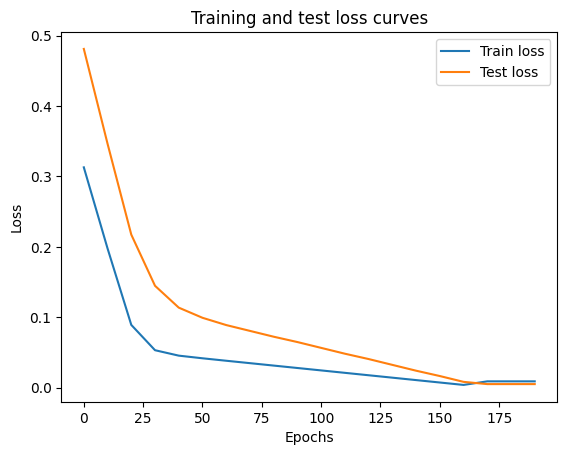

In [82]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [83]:
# 1 epoch
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [84]:
# actual weight and bias
weight, bias

(0.7, 0.3)

In [85]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

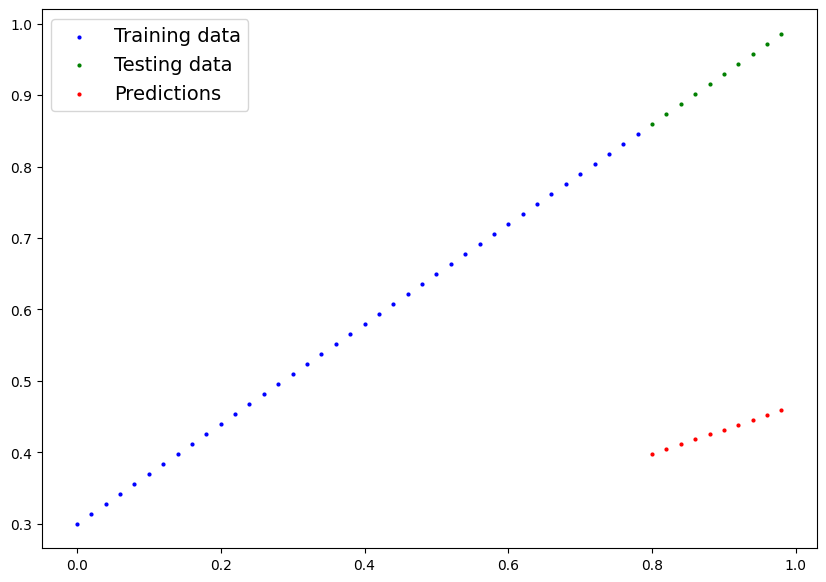

In [86]:
# Earlier predictions (random)
plot_predictions(predictions=y_preds)

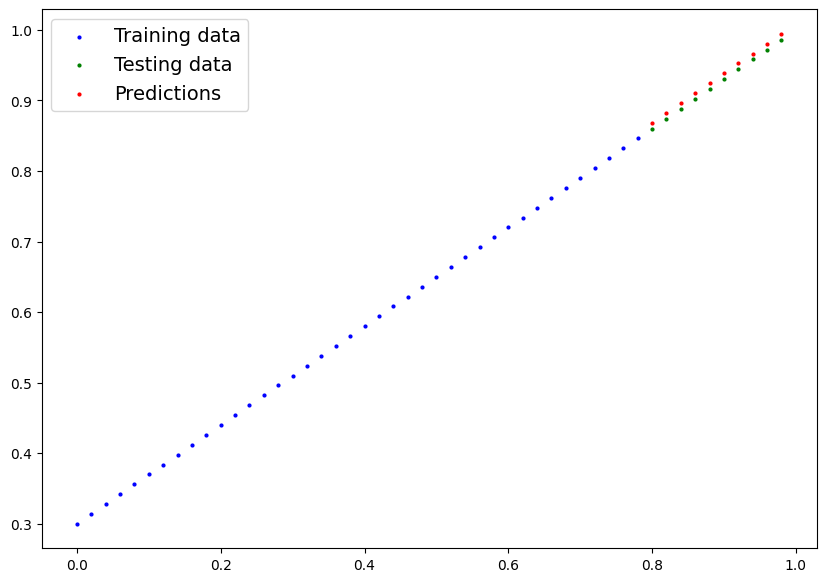

In [87]:
# New predictions
plot_predictions(predictions=y_preds_new)

In [88]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## Saving a model in PyTorch

Three main methods:
1. `torch.save()` save PyTorch object in python pickle object
2. `torch.load()` load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` allows to load a model's saved state dict

In [89]:
# Saving the model
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # or .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save model's state_dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [90]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Jan 17 15:29 01_pytorch_workflow_model_0.pth


## Loading model

We saved our model's `state_dict()`, we create a new instance of model class and load the saved `state_dict()`

In [91]:
MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [92]:
# Create a new instance of model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [93]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [94]:
# Make predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [95]:
# Predictions of initial model (check if the predictions are equal)
model_0.eval()
with torch.inference_mode():
  model_0_preds = model_0(X_test)

model_0_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [96]:
loaded_model_preds == model_0_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together
Redo everything

In [97]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__
torch.__version__

'2.1.0+cu121'

In [98]:
# Device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [99]:
# Creating data using y = weight * X + bias
weight = 0.5
bias = 0.8

start = 0
end = 1
step = 0.02

X_tensor = torch.arange(start, end, step).unsqueeze(1)
Y_tensor = weight * X_tensor + bias

X_tensor[:10], Y_tensor[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.8000],
         [0.8100],
         [0.8200],
         [0.8300],
         [0.8400],
         [0.8500],
         [0.8600],
         [0.8700],
         [0.8800],
         [0.8900]]))

In [100]:
# Training-test split 80-20
boundary = int(0.8 * len(X_tensor))
X_train = X_tensor[:boundary]
X_test = X_tensor[boundary:]

y_train = Y_tensor[:boundary]
y_test = Y_tensor[boundary:]

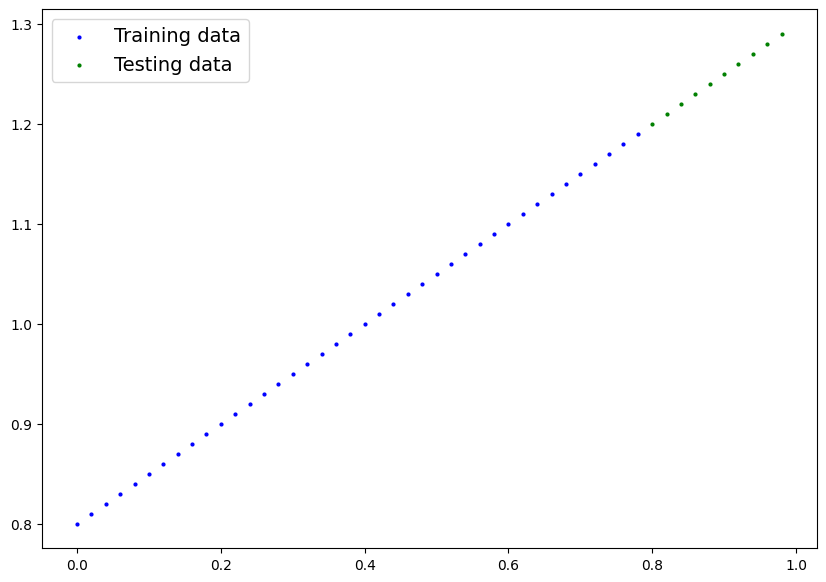

In [119]:
# Plot the data
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())

## Build linear model


In [103]:
# Create linaer model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [105]:
# Set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [106]:
# Set model to use correct device
next(model_1.parameters()).device

device(type='cpu')

In [109]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training
1. Loss function
2. Optimizer
3. Training loop
4. Testing loop

In [111]:
# Loss function
loss_fn = nn.L1Loss() # MAE

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

# Training loop
torch.manual_seed(42)

epochs = 200

# Device agnostic code for data (same as model)
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Back propagation
  loss.backward()

  # 5. Optimizer step (Gradient Descent)
  optimizer.step()

  # Testing loop
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Training loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Training loss: 0.13317792117595673 | Test loss: 0.25197625160217285
Epoch: 10 | Training loss: 0.05350856855511665 | Test loss: 0.14503729343414307
Epoch: 20 | Training loss: 0.03996611759066582 | Test loss: 0.10180991888046265
Epoch: 30 | Training loss: 0.03590356931090355 | Test loss: 0.08538384735584259
Epoch: 40 | Training loss: 0.03242634981870651 | Test loss: 0.075050950050354
Epoch: 50 | Training loss: 0.028987539932131767 | Test loss: 0.06677857786417007
Epoch: 60 | Training loss: 0.02555466629564762 | Test loss: 0.05919307470321655
Epoch: 70 | Training loss: 0.022122709080576897 | Test loss: 0.05092071369290352
Epoch: 80 | Training loss: 0.018683893606066704 | Test loss: 0.04264834150671959
Epoch: 90 | Training loss: 0.015252676792442799 | Test loss: 0.03506283834576607
Epoch: 100 | Training loss: 0.011819063685834408 | Test loss: 0.026790475472807884
Epoch: 110 | Training loss: 0.008380251005291939 | Test loss: 0.01851811446249485
Epoch: 120 | Training loss: 0.0049

In [112]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5052]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8005], device='cuda:0'))])

In [113]:
weight, bias

(0.5, 0.8)

### Making and evaluating predictions

In [114]:
# Eval mode
model_1.eval()

# Make predictions on test data
with torch.inference_mode():
  y_preds = model_1(X_test)

tensor([[1.2047],
        [1.2148],
        [1.2249],
        [1.2350],
        [1.2451],
        [1.2552],
        [1.2653],
        [1.2754],
        [1.2855],
        [1.2956]], device='cuda:0')

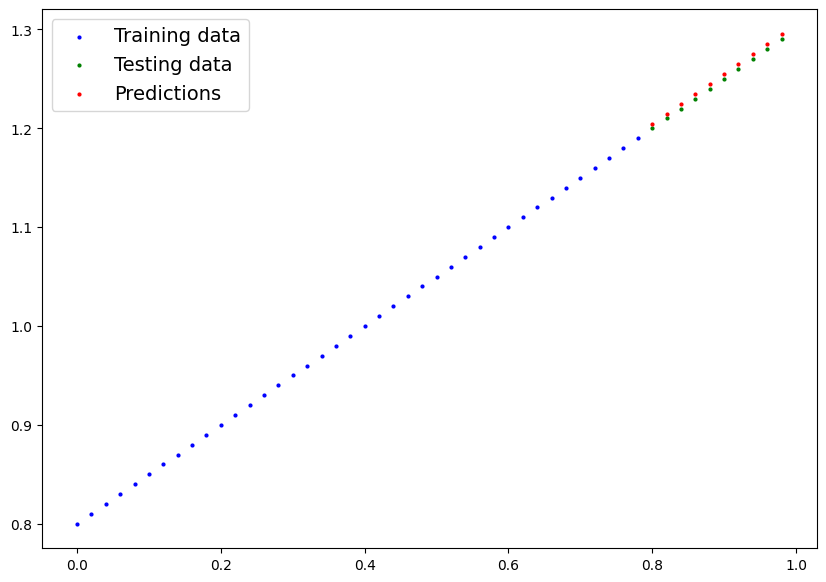

In [123]:
# Plot the predictions

plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

# Saving and loading a trained model

In [128]:
# Saving the state_dict

from pathlib import Path
# 1. Create module directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents="True", exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model
torch.save(model_1.state_dict(), MODEL_SAVE_PATH)

In [131]:
# Load a PyTorch model

# Create new instance
loaded_model_1 = LinearRegressionModelV2()

# Load the state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [132]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5052]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8005], device='cuda:0'))])

In [133]:
# Evaluate loaded model

loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1.preds = loaded_model_1(X_test)

y_preds == loaded_model_1.preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

### EXERCISES

In [188]:
# Device agnostic code
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [189]:
# Q1

weight=0.3
bias=0.9

start = 0
stop = 1
step = 0.01

X = torch.arange(start, stop, step).unsqueeze(dim=1)
Y = X*weight + bias

boundary = int(0.8*len(X))
X_train = X[:boundary]
X_test = X[boundary:]

y_train = Y[:boundary]
y_test = Y[boundary:]

len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

In [190]:
#Q2
import torch
from torch import nn
import matplotlib.pyplot as plt

In [191]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [192]:
class Exercise_LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1,
                                requires_grad=True,
                                dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                            requires_grad=True,
                            dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [193]:
exercise_model = Exercise_LinearRegression()
exercise_model.to(device)
exercise_model.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

In [194]:
# Q3
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=exercise_model.parameters(), lr=0.01)

In [195]:
torch.manual_seed(42)

epochs = 300

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  # Training loop
  exercise_model.train()
  y_pred = exercise_model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  # Testing loop
  exercise_model.eval()
  with torch.inference_mode():
    test_pred = exercise_model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Training Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Training Loss: 0.7566978931427002 | Test Loss: 0.7248174548149109
Epoch: 10 | Training Loss: 0.6410953402519226 | Test Loss: 0.5894648432731628
Epoch: 20 | Training Loss: 0.5254928469657898 | Test Loss: 0.4541124403476715
Epoch: 30 | Training Loss: 0.40989047288894653 | Test Loss: 0.31876006722450256
Epoch: 40 | Training Loss: 0.2942880392074585 | Test Loss: 0.18340764939785004
Epoch: 50 | Training Loss: 0.17868565022945404 | Test Loss: 0.04805523157119751
Epoch: 60 | Training Loss: 0.07658576965332031 | Test Loss: 0.07274086028337479
Epoch: 70 | Training Loss: 0.05743539333343506 | Test Loss: 0.11017072200775146
Epoch: 80 | Training Loss: 0.05255373939871788 | Test Loss: 0.11581540107727051
Epoch: 90 | Training Loss: 0.04897591471672058 | Test Loss: 0.11232650279998779
Epoch: 100 | Training Loss: 0.04554273188114166 | Test Loss: 0.10467890650033951
Epoch: 110 | Training Loss: 0.0421157144010067 | Test Loss: 0.09703131765127182
Epoch: 120 | Training Loss: 0.03868867084383964

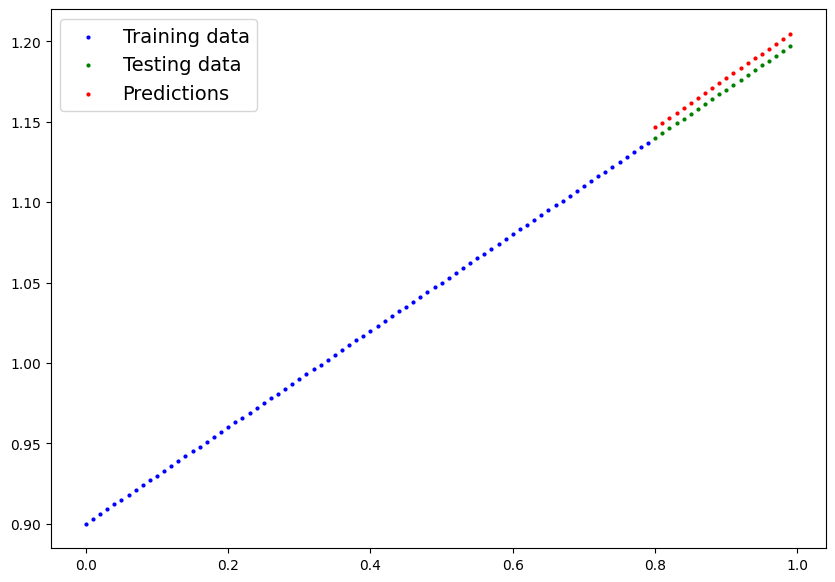

In [196]:
with torch.inference_mode():
  plot_predictions(predictions=test_pred.cpu())

In [197]:
test_pred

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740],
        [1.1771],
        [1.1801],
        [1.1832],
        [1.1863],
        [1.1893],
        [1.1924],
        [1.1955],
        [1.1985],
        [1.2016],
        [1.2047]], device='cuda:0')

In [198]:
exercise_model.state_dict()

OrderedDict([('weights', tensor([0.3067], device='cuda:0')),
             ('bias', tensor([0.9011], device='cuda:0'))])